In [52]:
import pandas as pd
#from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm

In [ ]:
train_df = pd.read_excel("self_training_annotated.xlsx", sheet_name="Sheet1", usecols=[5, 8, 9, 14, 16])
training_sample = train_df.groupby('language', group_keys=False).sample(n=20)
training_sample.columns

Index(['language', 'original_string', 'original_docstring', 'short_docstring',
       'modified_short_docstring'],
      dtype='object')
Length =  200


In [17]:
llm_set:list[dict] = []

for instance in tqdm(training_sample.itertuples()):
    language = instance.language
    original_doc = instance.original_docstring
    original_code = instance.original_string
    positive = instance.modified_short_docstring
    negative = instance.short_docstring

 
    llm_set.append({
        "code": original_code,
        "original_doc": original_doc,
        "candidate_sentence": positive,
        "label": 1
    })

    llm_set.append({
        "code": original_code,
        "original_doc": original_doc,
        "candidate_sentence": negative,
        "label": 0
    })



0it [00:00, ?it/s]

In [36]:
train_df = pd.DataFrame(llm_set)
train_df = train_df.dropna()
train_df.head()

,code,original_doc,candidate_sentence,label
0,"int stab_fun(string str){\n_x0001_if(str!=""pup...",// This lets the player stab the guardian pupp...,/*Accepts a string argument.\nThis lets the pl...,1
1,"int stab_fun(string str){\n_x0001_if(str!=""pup...",// This lets the player stab the guardian pupp...,"This lets the player stab the guardian puppet,...",0
2,LABIRINTO* alocalabirinto(void){\n LABIRINT...,//aloca a quantidade de memoria necessaria par...,// Allocates the amount of memory needed for a...,1
3,LABIRINTO* alocalabirinto(void){\n LABIRINT...,//aloca a quantidade de memoria necessaria par...,aloca a quantidade de memoria necessaria para ...,0
4,static inline void soc_eu_selEventTimer(unsign...,/** \brief Select event to be propagated to ti...,/*Accepts 2 unsigned integers.\nSelects the ev...,1


In [41]:
X = train_df.drop('label', axis=1)
y = train_df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# Define transformers
preprocessor = ColumnTransformer(transformers=[
    ('tfidf_1', TfidfVectorizer(), 'code'),
    ('tfidf_2', TfidfVectorizer(), 'original_doc'),
    ('tfidf_3', TfidfVectorizer(), 'candidate_sentence')
])

# Full pipeline with classifier
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier())
])

In [51]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.58        59
           1       0.43      0.33      0.37        49

    accuracy                           0.50       108
   macro avg       0.48      0.49      0.48       108
weighted avg       0.49      0.50      0.49       108



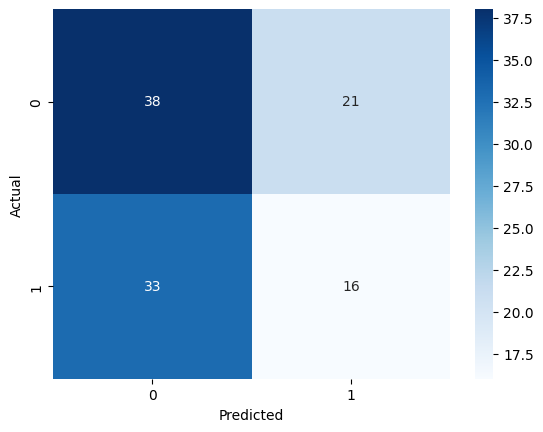

In [53]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()